# ResNet RNN to predict next state

We aim to predict the next steps on time series

In [13]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pprint as pprint
import math
import time

In [14]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.3.1


In [15]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import os
import json
import pickle
import sklearn
from sklearn import neighbors

In [16]:
import import_ipynb

import Process_Training_Data_2

from Process_Training_Data_2 import norm
from Process_Training_Data_2 import denorm
from Process_Training_Data_2 import class_to_action
from Process_Training_Data_2 import closest_category
from Process_Training_Data_2 import extend_dataset
from Process_Training_Data_2 import normalize_data
from Process_Training_Data_2 import print_model_df_analysis
from Process_Training_Data_2 import group_by_path
from Process_Training_Data_2 import get_mean_error
from Process_Training_Data_2 import add_end_state
from Process_Training_Data_2 import multiplex_trajectories

### Get the data
First Import it using pandas

In [3]:
file = "OSPA_training_data.csv"

In [30]:
#STEPS = 50

dataset = Process_Training_Data_2.get_data("./data/"+file)

dataset_distances= dataset[["id_camino","D0",'D1',"D2","D3",'D4',"D5","A0","A1"]]

#exteneded_dataset= add_end_state(dataset_distances)
exteneded_dataset = dataset_distances

action_vector = []
normed_dataset, data_stats = Process_Training_Data_2.normalize_data(exteneded_dataset, action_vector)

#position = "post"
#dataset2 = Process_Training_Data_2.padding(normed_dataset,STEPS,position)

pre_dataset = group_by_path(normed_dataset)

dataset2 = multiplex_trajectories(pre_dataset)

In [5]:
Zero_Target= [0,0,0,0,0,0]
ZT_norm = norm(Zero_Target, data_stats)
ZT_norm 

D0    0.0
D1    0.0
D2    0.0
D3    0.0
D4    0.0
D5    0.0
Name: std, dtype: float64

### Split the data into train and test

Now split the dataset into a training set and a test set.

We take the first TRAIN_SPLIT values as train data

We will use the test set in the final evaluation of our model.

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [6]:
def multivariate_data(dataset, target, start_index, end_index, return_sequences):
  data = []
  labels = []

  if end_index is None:
    end_index = len(dataset)

  for i in range(start_index, end_index):
    indices = range(0, len(dataset[i])-1)
    data.append(dataset[i][indices])
    if return_sequences:
      labels.append(target[i][1:])   
    else:
      labels.append(target[i][-1])
      
  return np.array(data), np.array(labels)

## single step model using sequential output
Given a sequence of actions, the model should predict the same sequency one step in the future

### Split features from labels

In [9]:
np.random.shuffle(dataset2)

In [10]:
TRAIN_SPLIT = int(len(dataset2)*0.8)
features_dataset = dataset2[:]
target_dataset = dataset2[:]
return_sequences= False
#features_dataset = dataset2[:,:,:6]
#target_dataset = dataset2[:,0:,:6]

x_train_single_sequential, y_train_single_sequential = multivariate_data(features_dataset, target_dataset,0, TRAIN_SPLIT, return_sequences)

x_val_single_sequential, y_val_single_sequential = multivariate_data(features_dataset, target_dataset, TRAIN_SPLIT, None, return_sequences)

### Build the model

In [17]:
single_step_sequential_model = tf.keras.models.Sequential([
tf.keras.layers.Input(shape=[None, 6], ragged=True, dtype =tf.float64),
tf.keras.layers.LSTM(11,return_sequences=False, dtype =tf.float64)])
single_step_sequential_model.add(tf.keras.layers.Dense(6, activation='linear', dtype =tf.float64))

loss_fn = tf.keras.losses.MeanSquaredError()

single_step_sequential_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse', metrics=['mse','mae'])

### Inspect the model

In [18]:
single_step_sequential_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 11)                792       
_________________________________________________________________
dense (Dense)                (None, 6)                 72        
Total params: 864
Trainable params: 864
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [47]:
r_x_train_single_sequential= tf.ragged.constant(x_train_single_sequential)
r_x_val_single_sequential= tf.ragged.constant(x_val_single_sequential)

In [13]:
BATCH_SIZE = 1
STEPS_PER_EPOCH = TRAIN_SPLIT / BATCH_SIZE
EPOCHS = 100

single_step_sequential_history = single_step_sequential_model.fit(x= r_x_train_single_sequential, y= y_train_single_sequential, batch_size =  BATCH_SIZE, epochs=EPOCHS, validation_data=(r_x_val_single_sequential,y_val_single_sequential))

Train on 192 samples, validate on 48 samples
Epoch 1/100
192/192 [==============================] - 4s 23ms/step - loss: 0.7372 - mse: 0.7372 - mae: 0.5173 - val_loss: 0.7190 - val_mse: 0.7190 - val_mae: 0.4721
Epoch 2/100
192/192 [==============================] - 2s 13ms/step - loss: 0.5834 - mse: 0.5834 - mae: 0.4476 - val_loss: 0.5793 - val_mse: 0.5793 - val_mae: 0.4253
Epoch 3/100
192/192 [==============================] - 2s 13ms/step - loss: 0.4541 - mse: 0.4541 - mae: 0.3963 - val_loss: 0.4606 - val_mse: 0.4606 - val_mae: 0.3767
Epoch 4/100
192/192 [==============================] - 3s 15ms/step - loss: 0.3599 - mse: 0.3599 - mae: 0.3496 - val_loss: 0.3909 - val_mse: 0.3909 - val_mae: 0.3422
Epoch 5/100
192/192 [==============================] - 3s 15ms/step - loss: 0.3133 - mse: 0.3133 - mae: 0.3221 - val_loss: 0.3561 - val_mse: 0.3561 - val_mae: 0.3227
Epoch 6/100
192/192 [==============================] - 3s 13ms/step - loss: 0.2884 - mse: 0.2884 - mae: 0.3070 - val_loss: 0.

In [14]:
N_CATEGORIES = 28
X = pd.DataFrame(columns=["A0", "A1"], dtype=np.float64, index=range(N_CATEGORIES))

for i in range(N_CATEGORIES):
    X["A0"][i] = class_to_action(str(i))[0]
    X["A1"][i] = class_to_action(str(i))[1]


In [15]:
test_loss, test_mse, test_mae = single_step_sequential_model.evaluate(r_x_val_single_sequential,  y_val_single_sequential, verbose=2)

Visualize the model's training progress.

In [16]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

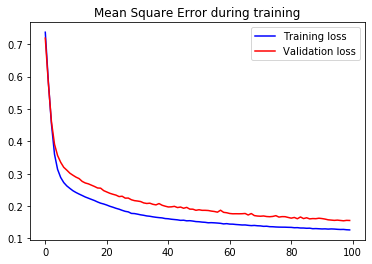

In [17]:
plot_train_history(single_step_sequential_history,
                   'Mean Square Error during training')

#### Adding early stop

In [21]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history_sequential = single_step_sequential_model.fit(x= x_train_single_sequential, y= y_train_single_sequential, epochs=EPOCHS,batch_size =  BATCH_SIZE, validation_data=(x_val_single_sequential,  y_val_single_sequential), verbose=0, callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0788,  mae:0.1613,  mse:0.0788,  val_loss:0.1147,  val_mae:0.1830,  val_mse:0.1147,  
.................................

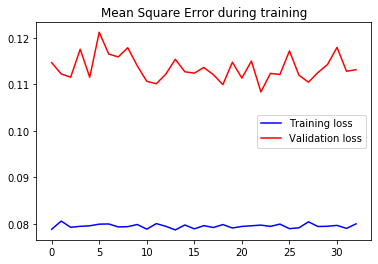

In [22]:
plot_train_history(early_history_sequential,
                   'Mean Square Error during training')

In [46]:
single_step_sequential_model.save("./data/S2S_S2S_ODE.h5") 

## Decoder Mode

In [33]:
def generate_trajectory_Decoder(model, start, target, initial_action, data_stats):

    model.reset_states()

    # initialize cost
    cost = 0

    # Empty vector to store the actions
    actions = []

    #initialize action vector
    actions.append(initial_action)

    # First point is the initial distance

    # Compute the initial distance
    distance_long = target - start
    
    # normalize to get the Neuronal Network input
    distance = norm(distance_long[0:6], data_stats)
    trajectory_generated = tf.expand_dims([distance], 0)


    for i in range(100):

        dummy_trajectory=model.predict(trajectory_generated)
        last_step = np.reshape(dummy_trajectory[-1,:],(1,1,6))

        if  (last_step[0,0,0] <= 0.02):
            last_step[0,0,0] = 0
            trajectory_generated=np.append(trajectory_generated, last_step, axis=1)
            end_message = "End"
            break

        trajectory_generated=np.append(trajectory_generated, last_step, axis=1)
        end_message = "Error"
    

    New_trajectory = np.squeeze(trajectory_generated)

    trajectory_generated_denorm = np.apply_along_axis(denorm,1,New_trajectory,data_stats)

    return trajectory_generated_denorm, cost, actions, end_message


## Get validation statistics

In [21]:
model = tf.keras.models.load_model("./data/S2S_S2S_ODE.h5")
#model = tf.keras.models.load_model("./data/S2S_S2S_model_2_OSPA_training_data 2.csv.h5")

In [22]:
def distance_error(x, z):
    distancia = math.sqrt(x**2 + z**2)
    return distancia

In [23]:
def get_trajectory_results(x_single_sequential, y_single_sequential, data_stats):
    results = pd.DataFrame(columns = ["path", "actions", "distance", "cost", "mean_distance","end_message"])

    for t_number in range(len(y_single_sequential)):

        x_denorm = np.apply_along_axis(denorm,1,x_single_sequential[t_number],data_stats)

        y_denorm = np.apply_along_axis(denorm,1,y_single_sequential[t_number],data_stats)

        initial_action = [0,0]
        start = [0.0, 0.0, 4.257165346815115, 0.0, 0, 0]
        target = x_denorm[0] + start

        start_time = time.time()

        trajectory, cost, actions, end_message = generate_trajectory_Decoder(model, start, target, initial_action, data_stats)

        t_time = time.time() - start_time

        pred_trajectory_states = target - trajectory
        OSPA_trajectory_states =  target - y_denorm
        OSPA_trajectory_states=np.insert(OSPA_trajectory_states,0,start, axis=0)

        min_len = min(len(y_denorm),len(trajectory[1:]))

        mse =sklearn.metrics.mean_squared_error(OSPA_trajectory_states[0:min_len,0:2], pred_trajectory_states[0:min_len,0:2])

        results.at[t_number, "time"] = t_time
        results.at[t_number, "actions"] = np.array(actions)
        results.at[t_number, "path"] = np.array(trajectory)
        results.at[t_number, "sqrt(trajectory MSE)"] = math.sqrt(mse)
        results.at[t_number, "cost"] = cost
        results.at[t_number, 'distance_to_target'] = distance_error(*trajectory[-1,0:2])
        results.at[t_number, 'end_message'] = end_message
        results.at[t_number, "mean_distance_in_trajectory"] = get_mean_error(OSPA_trajectory_states, pred_trajectory_states, num=10, eps = 5)
        results.at[t_number, "k_value"] = abs(target[1])/abs(target[0])
        results.at[t_number, "u_at_target"] = pred_trajectory_states[-1,2]
        results.at[t_number, "v_at_target"] =distance_error(pred_trajectory_states[-1,2], pred_trajectory_states[-1,3])
        results.at[t_number, "theta_at_target"] = pred_trajectory_states[-1,4]
        "u_at_target"

    return results


In [24]:
def get_trajectory_results_2(trajectoty_list, data_stats):
    results = pd.DataFrame(columns = ["path", "actions", "distance", "cost", "mean_distance","end_message"])

    for t_number in range(len(trajectoty_list)):

        initial_action = [0,0]
        start = trajectoty_list[t_number][0,-2]
        target = trajectoty_list[t_number][0,-1]

        start_time = time.time()

        trajectory, cost, actions, end_message = generate_trajectory_Decoder(model, start, target, initial_action, data_stats)

        t_time = time.time() - start_time

        pred_trajectory_states = target - trajectory
        OSPA_trajectory_states =  trajectoty_list[t_number][:,0:6]

        min_len = min(len(OSPA_trajectory_states),len(trajectory))

        mse =sklearn.metrics.mean_squared_error(OSPA_trajectory_states[0:min_len,0:2], pred_trajectory_states[0:min_len,0:2])


        results.at[t_number, "time"] = t_time
        results.at[t_number, "actions"] = np.array(actions)
        results.at[t_number, "path"] = np.array(trajectory)
        results.at[t_number, "sqrt(trajectory MSE)"] = math.sqrt(mse)
        results.at[t_number, "cost"] = cost
        results.at[t_number, 'distance_to_target'] = distance_error(*trajectory[-1,0:2])
        results.at[t_number, 'end_message'] = end_message
        results.at[t_number, "mean_distance_in_trajectory"] = get_mean_error(OSPA_trajectory_states, pred_trajectory_states, num=10, eps = 5)
        results.at[t_number, "k_value"] = abs(target[1])/abs(target[0])
        results.at[t_number, "u_at_target"] = pred_trajectory_states[-1,2]
        results.at[t_number, "v_at_target"] =distance_error(pred_trajectory_states[-1,2], pred_trajectory_states[-1,3])
        results.at[t_number, "theta_at_target"] = pred_trajectory_states[-1,4]
        "u_at_target"

    return results

In [26]:
def results_summary(results, metrics):
    results_summary = pd.DataFrame(columns = ["all","result_end", "result_error"])
    
    for metric in metrics:
        results_summary.at[metric, "result_end"] = results[metric].loc[results['end_message'] == "End"].mean()
        results_summary.at[metric, "result_error"] = results[metric].loc[results['end_message'] == "Error"].mean()
        results_summary.at[metric, "all"] = results[metric].mean()

    print(results["time"].loc[results['end_message'] == "Error"].count()/len(results))
    return results_summary

## Datos globales

In [27]:
dataset_trajectories = dataset[["id_camino","C0",'C1',"C2","C3",'C4',"C5","A0","A1","initial_state", "goal_state"]]

In [28]:
trajectory_list = group_by_path(dataset_trajectories)

In [34]:
full_results= get_trajectory_results_2(trajectory_list, data_stats)

In [35]:
metrics = ["time",'distance_to_target', "u_at_target","v_at_target","theta_at_target","mean_distance_in_trajectory","sqrt(trajectory MSE)", "k_value"]
results_summary(full_results, metrics)

0.0


,all,result_end,result_error
time,0.527673,0.527673,NaN
distance_to_target,1.65632,1.65632,NaN
u_at_target,9.06879,9.06879,NaN
v_at_target,9.08704,9.08704,NaN
theta_at_target,0.230126,0.230126,NaN
mean_distance_in_trajectory,2.51786,2.51786,NaN
sqrt(trajectory MSE),4.33613,4.33613,NaN
k_value,0.354392,0.354392,NaN


In [36]:
def plot_trajectory(x_single_sequential, y_single_sequential, data_stats, t_number):
    
    x_denorm = np.apply_along_axis(denorm,1,x_single_sequential[t_number],data_stats)

    y_denorm = np.apply_along_axis(denorm,1,y_single_sequential[t_number],data_stats)

    initial_action = [0,0]
    start = [0.0, 0.0, 4.257165346815115, 0.0, 0, 0]
    target = x_denorm[0] + start


    trajectory= model.predict(tf.expand_dims(x_single_sequential[t_number],0))

    New_trajectory = np.squeeze(trajectory)

    trajectory_denorm = np.apply_along_axis(denorm,1,New_trajectory,data_stats)

    pred_trajectory_states = target - trajectory_denorm
    OSPA_trajectory_states =  target - y_denorm
    OSPA_trajectory_states=np.insert(OSPA_trajectory_states,0,start, axis=0)
    pred_trajectory_states=np.insert(pred_trajectory_states,0,start, axis=0)
  
    plt.figure()

    plt.plot(pred_trajectory_states[:,0], pred_trajectory_states[:,1], c='g', label='RNN prediction')
    # plt.plot(ANN_trajectory_states[:,0], ANN_trajectory_states[:,1], c='b', label="ANN prediction")
    plt.plot(OSPA_trajectory_states[:,0], OSPA_trajectory_states[:,1], c='r', label='OSPA')
    plt.scatter(target[0],target[1], c='g', label='Goal state')
    plt.scatter(start[0], start[1], c='y', label='Start state')
    plt.title("trajectory x,z states")
    plt.legend()

    plt.show()

    fig, axs = plt.subplots(4)

    for i in range(4):

        component= i+2

        axs[i].plot(pred_trajectory_states[:,0],pred_trajectory_states[:,component], c='b', label='RNN Prediction')
        axs[i].plot(OSPA_trajectory_states[:,0], OSPA_trajectory_states[:,component],  c='r', label='OSPA')
        axs[i].scatter(target[0],target[component], c='g', label='Goal state')
        axs[i].scatter(start[0], start[component], c='y', label='Start start')

    fig.suptitle("trajectory components (u, v, theta, q) vs x")

    fig.show()

In [37]:
def plot_trajectory_2(trajectory_list, data_stats, t_number):

    initial_action = [0,0]
    start = trajectory_list[t_number][0,-2]
    target = trajectory_list[t_number][0,-1]

    trajectory, cost, actions, end_message = generate_trajectory_Decoder(model, start, target, initial_action, data_stats)

    pred_trajectory_states = target - trajectory
    OSPA_trajectory_states =  trajectory_list[t_number][:,0:6]
    # ANN_trajectory_states = ANN_dataset["states"][t_number]


    plt.figure()

    plt.plot(pred_trajectory_states[:,0], pred_trajectory_states[:,1], c='g', label='RNN prediction')
    # plt.plot(ANN_trajectory_states[:,0], ANN_trajectory_states[:,1], c='b', label="ANN prediction")
    plt.plot(OSPA_trajectory_states[:,0], OSPA_trajectory_states[:,1], c='r', label='OSPA')
    plt.scatter(target[0],target[1], c='g', label='Goal state')
    plt.scatter(start[0], start[1], c='y', label='Start state')
    plt.title("trajectory x,z states")
    plt.legend()

    plt.show()

    fig, axs = plt.subplots(4)

    for i in range(4):

        component= i+2

        axs[i].plot(pred_trajectory_states[:,0],pred_trajectory_states[:,component], c='b', label='RNN Prediction')
        axs[i].plot(OSPA_trajectory_states[:,0], OSPA_trajectory_states[:,component],  c='r', label='OSPA')
        axs[i].scatter(target[0],target[component], c='g', label='Goal state')
        axs[i].scatter(start[0], start[component], c='y', label='Start start')

    fig.suptitle("trajectory components (u, v, theta, q) vs x")

    fig.show()

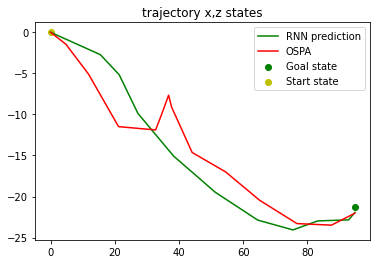

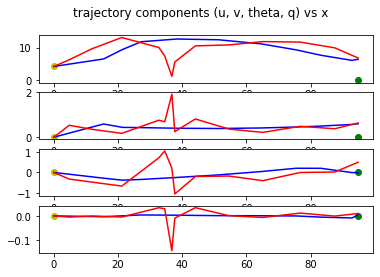

In [45]:
t_number = 55
plot_trajectory_2(trajectory_list, data_stats, t_number)

In [46]:
plot_trajectory(r_x_val_single_sequential, y_val_single_sequential, data_stats, 3)

NameError: name 'r_x_val_single_sequential' is not defined

In [80]:
validation_results= get_trajectory_results(r_x_val_single_sequential, y_val_single_sequential, data_stats)

In [83]:
results_summary(validation_results, metrics)

0.0


,all,result_end,result_error
time,0.475037,0.475037,NaN
distance_to_target,1.39928,1.39928,NaN
u_at_target,7.58886,7.58886,NaN
v_at_target,7.60216,7.60216,NaN
theta_at_target,0.200925,0.200925,NaN
mean_distance_in_trajectory,1.59412,1.59412,NaN
sqrt(trajectory MSE),4.9858,4.9858,NaN
k_value,0.350669,0.350669,NaN
